In [4]:
!pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 1.5 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 1.3 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.5 MB/s  0:00:01

   ---------------------------------------- 0/2 [regex]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   ------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


c:\python3.9\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.9124 - loss: 0.2845 - val_accuracy: 0.9847 - val_loss: 0.0452
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9841 - loss: 0.0502 - val_accuracy: 0.9890 - val_loss: 0.0327
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9894 - loss: 0.0338 - val_accuracy: 0.9898 - val_loss: 0.0309
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9922 - loss: 0.0249 - val_accuracy: 0.9906 - val_loss: 0.0296
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9937 - loss: 0.0190 - val_accuracy: 0.9922 - val_loss: 0.0277
313/313 - 3s - 9ms/step - accuracy: 0.9922 - loss: 0.0277

✅ Test Accuracy: 99.22%


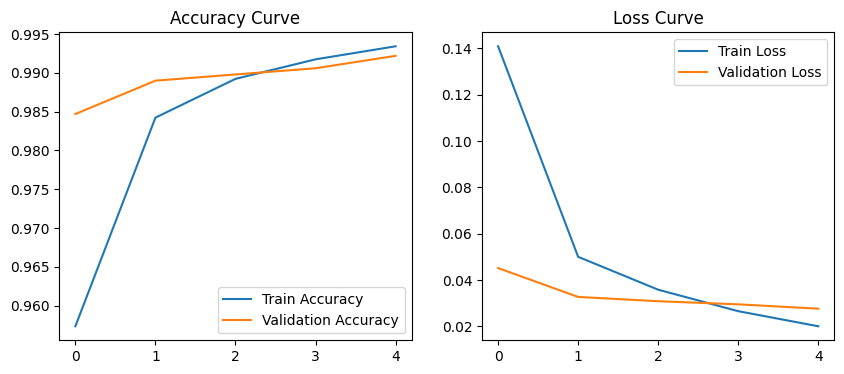

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


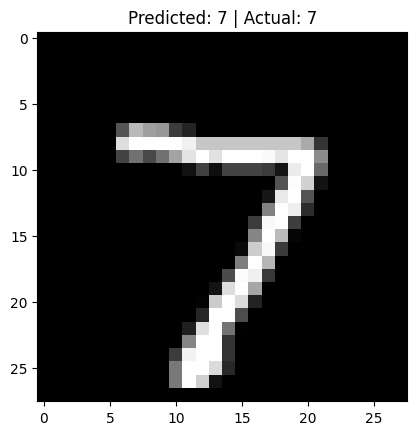

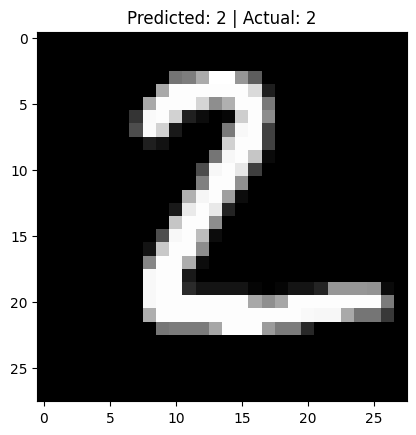

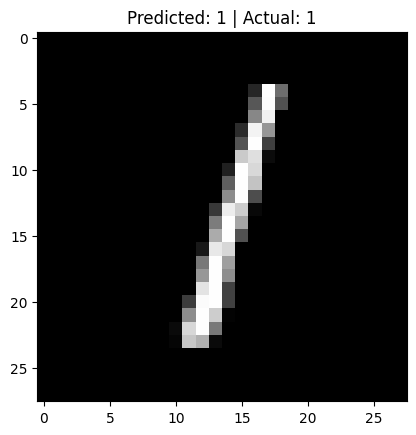

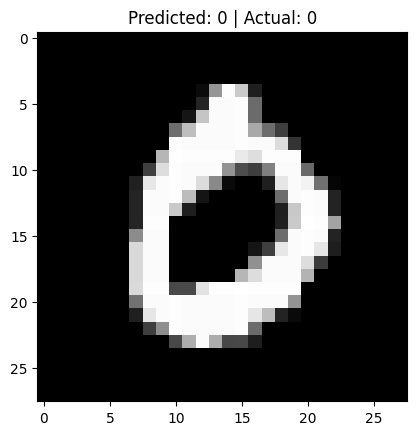

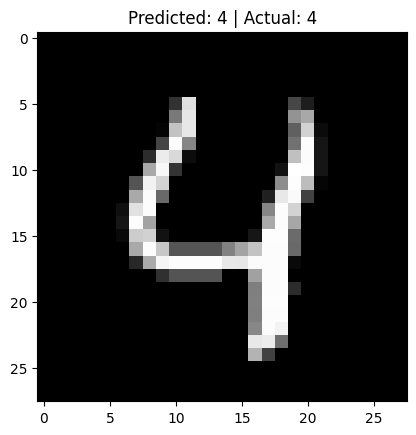

In [2]:
# 📘 Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ✅ Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 🔹 Normalize the data (0-255 → 0-1)
x_train, x_test = x_train / 255.0, x_test / 255.0

# 🔹 Add a channel dimension (for CNN)
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# 🧩 Build CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),             # Special: prevents overfitting
    layers.Dense(10, activation='softmax')
])

# 🧮 Compile Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 🚀 Train Model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# 📊 Evaluate Model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

# 🎨 Visualize Accuracy & Loss
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title("Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title("Loss Curve")

plt.show()

# 🔮 Make Predictions (just for fun)
predictions = model.predict(x_test[:5])
for i in range(5):
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.title(f"Predicted: {tf.argmax(predictions[i]).numpy()} | Actual: {y_test[i]}")
    plt.show()

In [ ]:
# %% [markdown]
# # 🧠 Text GAN using TensorFlow + NLTK (Story Generator)
# This notebook implements:
# - NLP preprocessing with NLTK
# - Text Generator (LSTM) using Gumbel-Softmax
# - Discriminator (CNN)
# - GAN training loop
# - Story generation with the trained model

# %% 
# 📦 Imports and Setup
import os
import random
import math
import json
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import nltk

# ✅ Fix for NLTK LookupError (downloads tokenizer data automatically)
nltk.download('punkt')
nltk.download('punkt_tab', quiet=True)

from nltk.tokenize import word_tokenize, sent_tokenize

# %% 
# ⚙️ Configuration
CFG = {
    "seq_len": 32,
    "embedding_dim": 128,
    "gen_units": 256,
    "disc_units": 256,
    "batch_size": 64,
    "epochs": 3,                 # small for demo — increase for better results
    "vocab_size": 2000,
    "learning_rate_gen": 1e-4,
    "learning_rate_disc": 1e-4,
    "gumbel_tau": 0.8,
    "save_dir": "./text_gan_checkpoints",
    "sample_every": 1,
    "seed": 42,
}

random.seed(CFG["seed"])
np.random.seed(CFG["seed"])
tf.random.set_seed(CFG["seed"])
os.makedirs(CFG["save_dir"], exist_ok=True)

# %% 
# 📚 Sample corpus (you can replace this with your own text file)
sample_corpus = """
Once upon a time there was a small village near the forest. In that village
lived a tailor who dreamed of adventure. He sewed clothes by day and read
books by night. One evening he found a mysterious map tucked inside a book.
The map showed a path through the forest to a hidden waterfall. Curious, he
packed a small bag and set off at dawn. The forest was full of birds and
strange flowers. After walking many hours he heard the roar of water. He
found the waterfall and a secret cave behind it. Inside, there was a chest
filled with letters from travelers. The tailor decided to write his own
letter and leave it in the chest for the next curious soul.
"""

# Duplicate to make a larger sample
corpus = (sample_corpus * 20).strip()

# %% 
# 🧹 Preprocessing
def preprocess_text(text, vocab_size=CFG["vocab_size"], seq_len=CFG["seq_len"]):
    text = text.replace("\n", " ").strip().lower()
    sents = sent_tokenize(text)
    tokens = []
    for s in sents:
        w = word_tokenize(s)
        tokens.extend(w + ["<eos>"])

    freq = {}
    for t in tokens:
        freq[t] = freq.get(t, 0) + 1

    special = ["<pad>", "<unk>", "<start>", "<eos>"]
    vocab_tokens = [t for t, _ in sorted(freq.items(), key=lambda x: x[1], reverse=True)][:vocab_size - len(special)]
    itos = special + vocab_tokens
    stoi = {t: i for i, t in enumerate(itos)}

    ids = [stoi.get(t, stoi["<unk>"]) for t in tokens]
    sequences = []
    i = 0
    while i < len(ids) - 1:
        seq = [stoi["<start>"]]
        while len(seq) < seq_len and i < len(ids):
            seq.append(ids[i])
            if ids[i] == stoi["<eos>"]:
                i += 1
                break
            i += 1
        if len(seq) < seq_len:
            seq += [stoi["<pad>"]] * (seq_len - len(seq))
        sequences.append(seq[:seq_len])
        i = i - (CFG["seq_len"] // 2) if i - (CFG["seq_len"] // 2) > 0 else i
    return np.array(sequences, dtype=np.int32), stoi, itos

sequences, stoi, itos = preprocess_text(corpus)
vocab_size = len(itos)
print("✅ Preprocessing complete")
print("Sequences shape:", sequences.shape, "Vocab size:", vocab_size)

# %%
# 🧾 Dataset Loader
def make_dataset(sequences, batch_size=CFG["batch_size"], shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(sequences)
    if shuffle:
        ds = ds.shuffle(10000, seed=CFG["seed"])
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

dataset = make_dataset(sequences)

# %% 
# 🎲 Gumbel Softmax Utilities
def sample_gumbel(shape, eps=1e-20):
    U = tf.random.uniform(shape, minval=0, maxval=1)
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, tau):
    g = sample_gumbel(tf.shape(logits))
    y = logits + g
    return tf.nn.softmax(y / tau)

def gumbel_softmax(logits, tau=CFG["gumbel_tau"], hard=False):
    y = gumbel_softmax_sample(logits, tau)
    if hard:
        y_hard = tf.one_hot(tf.argmax(y, axis=-1), tf.shape(y)[-1])
        y = tf.stop_gradient(y_hard - y) + y
    return y

# %% 
# 🧠 Generator and Discriminator
class TextGenerator(Model):
    def __init__(self, vocab_size, embedding_dim, gen_units, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.emb = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.lstm = layers.Bidirectional(layers.LSTM(gen_units, return_sequences=True))
        self.dense = layers.TimeDistributed(layers.Dense(vocab_size))

    def call(self, x, training=False):
        e = self.emb(x)
        h = self.lstm(e)
        logits = self.dense(h)
        return logits

    def sample_sequence(self, start_token_id, max_len=None, temperature=1.0):
        if max_len is None:
            max_len = self.seq_len
        emb_layer = self.emb
        lstm_cell = tf.keras.layers.LSTMCell(self.lstm.layer.units)
        dense = self.dense.layer if isinstance(self.dense, layers.TimeDistributed) else self.dense
        cur_id = tf.constant([[start_token_id]], dtype=tf.int32)
        states = lstm_cell.get_initial_state(batch_size=1, dtype=tf.float32)
        out_ids = []
        for _ in range(max_len):
            e = emb_layer(cur_id)
            e = tf.squeeze(e, axis=1)
            out, states = lstm_cell(e, states=states)
            logits = dense(out)
            probs = tf.nn.softmax(logits / temperature)
            next_id = tf.random.categorical(tf.math.log(probs), 1)
            next_id = tf.cast(next_id, tf.int32)
            out_ids.append(int(next_id.numpy()[0, 0]))
            cur_id = next_id
        return out_ids

class TextDiscriminator(Model):
    def __init__(self, vocab_size, embedding_dim, disc_units, seq_len):
        super().__init__()
        self.emb = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.conv1 = layers.Conv1D(128, 3, padding='same', activation='relu')
        self.pool = layers.GlobalMaxPool1D()
        self.dense = layers.Dense(disc_units, activation='relu')
        self.out = layers.Dense(1, activation='sigmoid')

    def call(self, x, training=False):
        e = self.emb(x)
        h = self.conv1(e)
        h = self.pool(h)
        h = self.dense(h)
        return self.out(h)

# %%
# 🚀 Instantiate models
generator = TextGenerator(vocab_size, CFG["embedding_dim"], CFG["gen_units"], CFG["seq_len"])
discriminator = TextDiscriminator(vocab_size, CFG["embedding_dim"], CFG["disc_units"], CFG["seq_len"])
_sample = tf.constant(sequences[:CFG["batch_size"]])
_ = generator(_sample)
_ = discriminator(_sample)

# %%
# 🧮 Optimizers and Losses
gen_optimizer = tf.keras.optimizers.Adam(CFG["learning_rate_gen"])
disc_optimizer = tf.keras.optimizers.Adam(CFG["learning_rate_disc"])
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# %%
# 🔁 Training Steps
@tf.function
def train_discriminator_step(real_x):
    with tf.GradientTape() as tape:
        logits = generator(real_x, training=True)
        y_soft = gumbel_softmax(logits, tau=CFG["gumbel_tau"], hard=True)
        fake_ids = tf.argmax(y_soft, axis=-1, output_type=tf.int32)
        real_scores = discriminator(real_x, training=True)
        fake_scores = discriminator(fake_ids, training=True)
        loss_real = bce(tf.ones_like(real_scores), real_scores)
        loss_fake = bce(tf.zeros_like(fake_scores), fake_scores)
        disc_loss = loss_real + loss_fake
    grads = tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    return disc_loss

@tf.function
def train_generator_step(real_x):
    with tf.GradientTape() as tape:
        logits = generator(real_x, training=True)
        y_soft = gumbel_softmax(logits, tau=CFG["gumbel_tau"], hard=True)
        fake_ids = tf.argmax(y_soft, axis=-1, output_type=tf.int32)
        fake_scores = discriminator(fake_ids, training=False)
        gen_loss = bce(tf.ones_like(fake_scores), fake_scores)
    grads = tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return gen_loss

# %%
# 🏋️ Training Loop
def decode_ids(ids, itos):
    return " ".join(
        [itos[i] for i in ids if itos[i] not in ["<pad>", "<start>", "<eos>"]]
    )

def sample_from_generator(generator, stoi, itos, temperature=1.0, max_len=CFG["seq_len"]):
    start_token = stoi.get("<start>", 2)
    ids = generator.sample_sequence(start_token, max_len=max_len, temperature=temperature)
    return decode_ids(ids, itos)

def train(dataset, epochs=CFG["epochs"]):
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        prog = tqdm(dataset, desc="Training")
        d_losses, g_losses = [], []
        for real_batch in prog:
            d_loss = train_discriminator_step(real_batch)
            g_loss = train_generator_step(real_batch)
            d_losses.append(float(d_loss))
            g_losses.append(float(g_loss))
            prog.set_postfix(D=np.mean(d_losses), G=np.mean(g_losses))
        print(f"📊 Epoch {epoch} - Disc: {np.mean(d_losses):.4f}, Gen: {np.mean(g_losses):.4f}")
        print("📝 Sample:", sample_from_generator(generator, stoi, itos))

# %%
# 🧩 Storytelling Helper
def tell_story(generator, stoi, itos, num_sentences=5, sentence_max_len=20, temperature=0.8):
    start_token = stoi.get("<start>", 2)
    story = []
    for _ in range(num_sentences):
        ids = generator.sample_sequence(start_token, max_len=sentence_max_len, temperature=temperature)
        story.append(decode_ids(ids, itos).capitalize() + ".")
    return " ".join(story)

# %%
# 🧠 Run training (short demo)
print("🚀 Starting small demo training...")
train(dataset, epochs=CFG["epochs"])

# %%
# 📖 Generate a short story
story = tell_story(generator, stoi, itos, num_sentences=6, temperature=0.9)
print("\n✨ Generated Story:\n")
print(story)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
